## scQuint Data annotation

In [1]:
##processing pipeline of cellxSJ matric StarSolo output for use with scQuint. Scripts by Gonzalo Benegas

In [2]:
!date

Wed Oct 25 15:36:33 PDT 2023


In [3]:
!echo $CONDA_PREFIX

/c4/home/derek/miniconda3/envs/scquint_4


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import re
from pyliftover import LiftOver

In [5]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [6]:
output_dir = '/c4/home/derek/data1/derek/data_scSLR/prenatal_brain/'

## load data from scquint differntial splicing

In [7]:
diff_spl_introns = pd.read_csv(output_dir+ 'diff_spliced_introns_all_equal.csv',index_col=0)
diff_spl_intron_groups = pd.read_csv(output_dir+'diff_spliced_intron_groups_all_equal.csv',index_col=0)

In [8]:
diff_spl_introns.name.nunique()

57218

In [9]:
sig_diff_spl_intron_groups = diff_spl_intron_groups.query('p_value_adj < 0.05')

sig_diff_spl_introns = diff_spl_introns[diff_spl_introns.intron_group.isin(sig_diff_spl_intron_groups.name)]


sig_diff_spl_intron_groups.shape

(4877, 12)

In [10]:
sig_diff_spl_introns.name.nunique()

7151

In [11]:
introns = pd.read_csv('sig_dfc_introns_PT.csv',index_col=0)

In [12]:
introns = sig_diff_spl_introns.drop_duplicates(['chromosome', 'start', 'end', 'strand', 'intron_motif', 'n_cells',
       'gene_id_start', 'gene_id_end', 'n_genes', 'gene_id', 'gene_name',
        'intron_group',
        'intron_group_size',
       'n_genes_per_intron_group']).drop(['psi_a','psi_b','delta_psi','lfc_psi','abs_delta_psi','abs_lfc_psi','test_group'],axis=1).reset_index(drop=True)

## annotate exons

In [13]:
##get HEXEvent database 

db = pd.read_csv('/c4/home/derek/data1/derek/reference/HEXEvent/result-2.txt',sep='\t')

##shift start coordinate to 1 based 
db['start'] = db['start'] +1

db['exon'] = db['chromo'].astype(str)+':'+db['start'].astype(str)+'-'+db['end'].astype(str)+':'+db['strand'].astype(str)

In [14]:
gtf_path = '/c4/home/derek/data1/derek/reference/Homo_sapiens.GRCh38.109.introns.gtf' #human_hp3_reference/genes/genes.gtf'
    
gtf = pd.read_csv(
    gtf_path,
    sep="\t",
    header=None,
    comment="#",
    names=[
        "chromosome",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
    ],
)

/scratch/derek/ipykernel_36471/3190734895.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf = pd.read_csv(


In [15]:
gtf_exon = gtf[gtf['feature'] == 'exon']

In [16]:
gtf_exon['transcript'] = gtf_exon.attribute.str.extract(r'Parent=([A-Za-z0-9]+);')

In [17]:
##get annotated mutually exclusive exons

gtf_path = '/c4/home/derek/data1/derek/reference/Hs_MXE_validated.gtf'
    
gtf_MXE = pd.read_csv(
    gtf_path,
    sep="\t",
    header=None,
    comment="#",
    names=[
        "chromosome",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
    ],
)

In [18]:
##liftover MXE coordinates from hg19 to hg38

lo = LiftOver('hg19', 'hg38')

new_coords = pd.DataFrame()

for index, row in gtf_MXE.iterrows():
    start = lo.convert_coordinate(row['chromosome'], row['start'])
    end = lo.convert_coordinate(row['chromosome'], row['end'])
    
    
    new_coords = pd.concat([new_coords,pd.DataFrame([start[0][1],end[0][1]]).T])
    
new_coords = new_coords.reset_index(drop=True)

gtf_MXE['start'] = new_coords[0]
gtf_MXE['end'] = new_coords[1]

In [19]:
gtf_MXE['gene_name'] = gtf_MXE.attribute.str.extract(r'gene_id "([A-Za-z0-9]+)";')

gtf_MXE['exon'] = gtf_MXE['chromosome'].astype(str)+':'+gtf_MXE['start'].astype(str)+'-'+gtf_MXE['end'].astype(str)+':'+gtf_MXE['strand'].astype(str)

In [22]:
gtf_MXE[gtf_MXE.gene_name == 'TCF4']

,chromosome,source,feature,start,end,score,strand,frame,attribute,gene_name,exon
781,chr18,kassiopeia,CDS,55403454,55403518,13.533835,-,1,"exon_id ""hsap00002418""; gene_id ""TCF4""; cluste...",TCF4,chr18:55403454-55403518:-
1106,chr18,kassiopeia,CDS,55398894,55398967,15.126050,-,1,"exon_id ""hsapMXE24881738""; gene_id ""TCF4""; clu...",TCF4,chr18:55398894-55398967:-


### get alt first and last exon annotations

In [20]:
gb = gtf_exon.groupby('transcript')

In [21]:
%%time
gtf_first_exon = gb.apply(lambda x: x.sort_values(by='start').iloc[0] if x.strand.iloc[0] == '+' \
                          else x.sort_values(by='end',ascending=False).iloc[0]
)

CPU times: user 1min 37s, sys: 2.19 s, total: 1min 39s
Wall time: 1min 39s


In [22]:
gtf_first_exon.loc[:,'chromo'] = 'chr'+gtf_first_exon['chromosome'].astype(str)
gtf_first_exon.loc[:,'end'] = gtf_first_exon.end
gtf_first_exon.loc[:,"genename"] = gtf_first_exon.attribute.str.extract(r'gene_name=([A-Za-z0-9]+);')
gtf_first_exon.loc[:,'exon'] = gtf_first_exon['chromo'].astype(str)+':'+gtf_first_exon['start'].astype(str)+'-'+gtf_first_exon['end'].astype(str)+':'+gtf_first_exon['strand'].astype(str)

In [23]:
%%time
gtf_last_exon = gb.apply(lambda x: x.sort_values(by='start').iloc[-1] if x.strand.iloc[0] == '+' \
                          else x.sort_values(by='end',ascending=False).iloc[-1]
)

CPU times: user 1min 37s, sys: 1.3 s, total: 1min 39s
Wall time: 1min 38s


In [24]:

gtf_last_exon.loc[:,'chromo'] = 'chr'+gtf_last_exon['chromosome'].astype(str)
gtf_last_exon.loc[:,'start'] = gtf_last_exon.start
gtf_last_exon.loc[:,"genename"] = gtf_last_exon.attribute.str.extract(r'gene_name=([A-Za-z0-9]+);')
gtf_last_exon.loc[:,'exon'] = gtf_last_exon['chromo'].astype(str)+':'+gtf_last_exon['start'].astype(str)+'-'+gtf_last_exon['end'].astype(str)+':'+gtf_last_exon['strand'].astype(str)


In [25]:
%%time

exon_dict = {}
event_type_dict = {}
length_dict = {}

db_count_dict = {}
constit_level_dict = {}



for index, row in introns.iterrows():

    if (((row['strand'] == '+') & (row['grouping'] == 'five_prime')) or ((row['strand'] == '-') & (row['grouping'] == 'three_prime'))):

        coord = row['end']+1 
        

        ##check for MXEs
        if coord in gtf_MXE['start'].values:
            exon = gtf_MXE[gtf_MXE['start'] == coord]
            
            call= exon['exon'].iloc[0]
            event_type = 'MXE'
            
            length = int(call.split(':')[1].split('-')[1]) -int(call.split(':')[1].split('-')[0]) 
            
            constit_level = 0
                    
        
        ##check for cassette exons
        elif coord in db['start'].values:
            exon = db[db['start'] == coord]
            
            call= exon['exon'].iloc[0]
            event_type = 'cassette'
            
            length = int(call.split(':')[1].split('-')[1]) -int(call.split(':')[1].split('-')[0])  
            
            constit_level = exon['constitLevel'].iloc[0]
            
            
        ##check for alt5s    
        elif coord in db[db['alt5singleLoc'] != '#']['alt5singleLoc'].str.split(',',expand=True).stack().reset_index()[0].values.astype(int)+1:   
            
            ind = db[db['alt5singleLoc'] != '#']['alt5singleLoc'].str.split(',',expand=True).stack(
            ).reset_index()[db[db['alt5singleLoc'] != '#']['alt5singleLoc'].str.split(',',expand=True).stack(
            ).reset_index()[0].values.astype(int) == (coord-1)]['level_0'].values[0]
            
            exon = db.iloc[ind]   
            
            call = exon['chromo']+':'+str(coord)+'-'+exon['end'].astype(str)+':'+exon['strand']
            
            if exon['strand'] == '+':
                event_type = None
            else:    
                event_type = 'alt5'
                
            length = int(call.split(':')[1].split('-')[1]) -int(call.split(':')[1].split('-')[0])  
            
            constit_level = 0

            
        #check for alt3s
        elif coord in db[db['alt3singleLoc'] != '#']['alt3singleLoc'].str.split(',',expand=True).stack().reset_index()[0].values.astype(int)+1:
            
            ind = db[db['alt3singleLoc'] != '#']['alt3singleLoc'].str.split(',',expand=True).stack(
            ).reset_index()[db[db['alt3singleLoc'] != '#']['alt3singleLoc'].str.split(',',expand=True).stack(
            ).reset_index()[0].values.astype(int) == (coord-1)]['level_0'].values[0]
            
            exon = db.iloc[ind]
            
            call = exon['chromo']+':'+str(coord)+'-'+exon['end'].astype(str)+':'+exon['strand']
            
            if exon['strand'] == '+':
                event_type = 'alt3'
            else:
                event_type = None
            
            length = int(call.split(':')[1].split('-')[1]) -int(call.split(':')[1].split('-')[0]) 

            constit_level = 0
        
        #check for alt35 & 5 - as cassette exons
        elif coord in db[db['alt3and5singleLoc'] != '#']['alt3and5singleLoc'].str.split(',',expand=True).stack().reset_index()[0].str.split('-',expand=True)[0].values.astype(int)+1:   ###+1
        
            ind = db[db['alt3and5singleLoc'] != '#']['alt3and5singleLoc'].str.split(',',expand=True).stack(
            ).reset_index()[db[db['alt3and5singleLoc'] != '#']['alt3and5singleLoc'].str.split(',',expand=True).stack(
            ).reset_index()[0].str.split('-',expand=True)[0].values.astype(int) == (coord-1)]['level_0'].iloc[0]
        
            
            exon = db.iloc[ind]
            
            for item in exon['alt3and5singleLoc'].split(','):
                if str(coord-1) in item.split('-'):
                    call_ = item
            
            call = exon['chromo']+':'+call_+':'+exon['strand']
            
            if exon['strand'] == '+':
                event_type = None
            else:    
                event_type = 'cassette'
                
            length = int(call.split(':')[1].split('-')[1]) -int(call.split(':')[1].split('-')[0])
            
            constit_level = 0
        
        #check for alt first exons
        elif coord in gtf_first_exon['start'].values:
            event_type = 'first_exon'
            
            call = gtf_first_exon[gtf_first_exon['start'] == coord]['exon'].iloc[0]
            
            length = int(call.split(':')[1].split('-')[1]) -int(call.split(':')[1].split('-')[0]) 
        
            constit_level = 0
            
        ##check for alt last exons
        elif coord in gtf_last_exon['start'].values:
            event_type = 'last_exon'
            call = gtf_last_exon[gtf_last_exon['start'] == coord]['exon'].iloc[0]
            
            length = int(call.split(':')[1].split('-')[1]) -int(call.split(':')[1].split('-')[0]) 
        
            constit_level = 0
        else:
            call = None
            event_type = None
            
            length = None
            
            constit_level = None
            
          
            
    else:
        coord = row['start']-1
        
        
        ##check for MXEs
        if coord in gtf_MXE['end'].values:
            exon = gtf_MXE[gtf_MXE['end'] == coord]
            
            call= exon['exon'].iloc[0]
            event_type = 'MXE'
            
            length = int(call.split(':')[1].split('-')[1]) -int(call.split(':')[1].split('-')[0]) 

            constit_level = 0
        #note cassette exons
        elif coord in db['end'].values:
            exon = db[db['end'] == coord]
            
            call= exon['exon'].iloc[0]
            event_type = 'cassette'
            
            length = int(call.split(':')[1].split('-')[1]) -int(call.split(':')[1].split('-')[0])
            
            constit_level = exon['constitLevel'].iloc[0]
            
        #check for alt5s 
        elif coord in db[db['alt3singleLoc'] != '#']['alt3singleLoc'].str.split(',',expand=True).stack().reset_index()[0].values.astype(int):
            
            ind = db[db['alt3singleLoc'] != '#']['alt3singleLoc'].str.split(',',expand=True).stack(
            ).reset_index()[db[db['alt3singleLoc'] != '#']['alt3singleLoc'].str.split(',',expand=True).stack(
            ).reset_index()[0].values.astype(int) == coord]['level_0'].iloc[0]
            
            exon = db.iloc[ind]
            
            call = exon['chromo']+':'+exon['start'].astype(str)+'-'+str(coord)+':'+exon['strand']
            
            if exon['strand'] == '+':
                event_type = None
            else:
                event_type = 'alt3'
            
            length = int(call.split(':')[1].split('-')[1]) -int(call.split(':')[1].split('-')[0])
            
            constit_level = 0
            
        #check for alt3s 
        elif coord in db[db['alt5singleLoc'] != '#']['alt5singleLoc'].str.split(',',expand=True).stack().reset_index()[0].values.astype(int):
            
            ind = db[db['alt5singleLoc'] != '#']['alt5singleLoc'].str.split(',',expand=True).stack(
            ).reset_index()[db[db['alt5singleLoc'] != '#']['alt5singleLoc'].str.split(',',expand=True).stack(
            ).reset_index()[0].values.astype(int) == coord]['level_0'].iloc[0]
            
            exon = db.iloc[ind]
            
            call = exon['chromo']+':'+exon['start'].astype(str)+'-'+str(coord)+':'+exon['strand']
            
            if exon['strand'] == '+':
                event_type = 'alt5'
            else:
                event_type = None
            
            length = int(call.split(':')[1].split('-')[1]) -int(call.split(':')[1].split('-')[0])
        
            constit_level = 0
            
        #check for alt35 & 5 - as cassette exons
        elif coord in db[db['alt3and5singleLoc'] != '#']['alt3and5singleLoc'].str.split(',',expand=True).stack().reset_index()[0].str.split('-',expand=True)[1].values.astype(int):
        
            ind = db[db['alt3and5singleLoc'] != '#']['alt3and5singleLoc'].str.split(',',expand=True).stack(
            ).reset_index()[db[db['alt3and5singleLoc'] != '#']['alt3and5singleLoc'].str.split(',',expand=True).stack(
            ).reset_index()[0].str.split('-',expand=True)[1].values.astype(int) == coord]['level_0'].iloc[0]
        
            
            exon = db.iloc[ind]
            
            for item in exon['alt3and5singleLoc'].split(','):
                if str(coord) in item.split('-'):
                    call_ = item
                
            
            call = exon['chromo']+':'+call_+':'+exon['strand']

            
            if exon['strand'] == '+':
                event_type = 'cassette'
            else:    
                event_type = None
            
            length = int(call.split(':')[1].split('-')[1]) -int(call.split(':')[1].split('-')[0])
        
            constit_level = 0
        
        elif coord in gtf_last_exon['end'].values:
            event_type = 'last_exon'
            call = gtf_last_exon[gtf_last_exon['end'] == coord]['exon'].iloc[0]
            
            length = int(call.split(':')[1].split('-')[1]) -int(call.split(':')[1].split('-')[0])
            
            constit_level = 0
            
        elif coord in gtf_first_exon['end'].values:
            event_type = 'first_exon'
            call = gtf_first_exon[gtf_first_exon['end'] == coord]['exon'].iloc[0]
            
            length = int(call.split(':')[1].split('-')[1]) -int(call.split(':')[1].split('-')[0])
        
            constit_level = 0
        else:
            call = None
            event_type = None
            
            length = None
            
            constit_level = None
            
            
    exon_dict[index] = call
    event_type_dict[index]= event_type
    length_dict[index] = length
    constit_level_dict[index] = constit_level

CPU times: user 2min 13s, sys: 681 ms, total: 2min 13s
Wall time: 2min 13s


In [26]:
introns['exon'] = introns.index.map(exon_dict)

introns['event_type'] = introns.index.map(event_type_dict)

introns['exon_length'] = introns.index.map(length_dict)

introns['constit_level'] = introns.index.map(constit_level_dict)

## refine annotations

In [160]:
constit_dict = {}

for name, group in introns.groupby('intron_group'):
    
    constit_idx = group['constit_level'].idxmax()
    
    constit_dict[name] = constit_idx
    
    

In [162]:
df = pd.DataFrame()

for index, row in introns.iterrows():
    if index in constit_dict.values():
        row['event_type'] = 'constitutive'

    
    df=pd.concat([df,pd.DataFrame(row).T])

In [28]:
outer_dict = {}

for group in introns['intron_group'].unique():
    #print(group)
    
    
    #define outer, encompassing splicing event, which will not have an alt exon associated, as the largest 
    #intron in the group 
    
    if group[-1] == '+':
        outer = introns.loc[[introns[introns['intron_group'] == group]['start'].idxmin()]]
        
    elif group[-1] == '-':
        outer = introns.loc[[introns[introns['intron_group'] == group]['end'].idxmax()]]
    
    
    
    outer_dict[group] = outer.index[0]

In [29]:
df = pd.DataFrame()

for index, row in introns.iterrows():
    if (index in outer_dict.values())  & (
        (row['event_type'] == 'cassette') | (row['event_type'] == 'first_exon') | (row['event_type'] == 'last_exon')):
        row['event_type'] = 'exclusion'

    
    df=pd.concat([df,pd.DataFrame(row).T])

In [32]:
df.to_csv('sig_dfc_introns_PT_annotated.csv')

In [114]:
threeprime_groupings = pd.read_csv('3prime_grouped_introns.csv',index_col=0)
fiveprime_groupings = pd.read_csv('5prime_grouped_introns.csv',index_col=0)

threeprime_groupings['intron'] = threeprime_groupings.index.to_frame()[0].str.split('_',expand=True)[1]
fiveprime_groupings['intron'] = fiveprime_groupings.index.to_frame()[0].str.split('_',expand=True)[1]

In [41]:
threeprime_groupings[threeprime_groupings.gene_name == 'STX2']

,chromosome,start,end,strand,intron_motif,n_cells,gene_id_start,gene_id_end,n_genes,gene_id,gene_name,intron_group,intron_group_size,n_genes_per_intron_group,grouping,intron
STX2_chr12:130798636-130799167,chr12,130798636,130799167,-,2,611,ENSG00000111450,NaN,1,ENSG00000111450,STX2,STX2_chr12_130798636_-,2,1,three_prime,chr12:130798636-130799167
STX2_chr12:130798636-130801152,chr12,130798636,130801152,-,2,1403,ENSG00000111450,ENSG00000111450,1,ENSG00000111450,STX2,STX2_chr12_130798636_-,2,1,three_prime,chr12:130798636-130801152


In [42]:
fiveprime_groupings[fiveprime_groupings.gene_name == 'STX2']

,chromosome,start,end,strand,intron_motif,n_cells,gene_id_start,gene_id_end,n_genes,gene_id,gene_name,intron_group,intron_group_size,n_genes_per_intron_group,grouping,intron
STX2_chr12:130798636-130801152,chr12,130798636,130801152,-,2,1403,ENSG00000111450,ENSG00000111450,1,ENSG00000111450,STX2,STX2_chr12_130801152_-,2,1,five_prime,chr12:130798636-130801152
STX2_chr12:130799191-130801152,chr12,130799191,130801152,-,2,532,NaN,ENSG00000111450,1,ENSG00000111450,STX2,STX2_chr12_130801152_-,2,1,five_prime,chr12:130799191-130801152


In [43]:
# #introns['annotated'] = 
# introns.event_type.apply(lambda x: 'constitutive' if db[db.exon == x].constitLevel == 1 \
#                                                 else 'variable')



In [44]:
sns.color_palette(palette='tab10')[:6]+['w']

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'w']

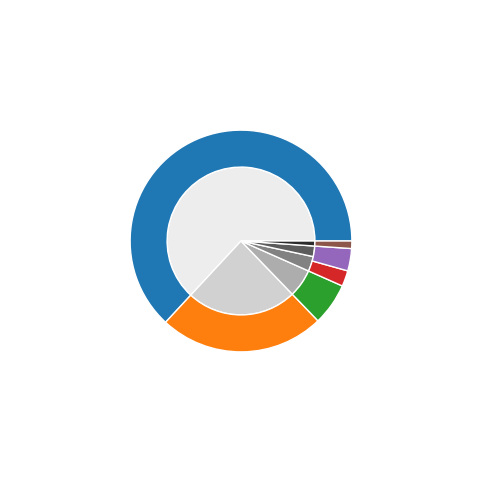

In [45]:
fig, ax = plt.subplots(figsize=(6, 6))


size = 0.4

ax.pie(introns['event_type'].value_counts(),
       radius=size, 
       colors=sns.color_palette(palette='Greys'),
       wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'},
       startangle=0
      )


ax.pie(introns['event_type'].value_counts().loc[['cassette','first_exon','last_exon','alt5','alt3','MXE']],
     # labels=introns['event_type'].value_counts().loc[['cassette','first_exon','last_exon','alt5','alt3','MXE','unannotated']].index,
      radius = 1-size,
      wedgeprops={'linewidth': 1.0, 'edgecolor': 'white', 'width':.2},
      textprops={'size': 'large'},
      colors=sns.color_palette(palette='tab10')[:6]+['w'],
 
      )

ax.set(aspect="equal")
fig.show()

In [ ]:
for group in introns['intron_group'].unique():


In [90]:
introns[introns['intron_group'] == 'RPL22_chr1_6186817_-']['event_type']

2

In [94]:

for index, row in introns.head(1000).iterrows():
    if (row['event_type'] == 'alt3') | (row['event_type'] == 'alt5'):
        intron_group = row['intron_group']
        print(introns[introns['intron_group'] == intron_group]['event_type'].size)

2
2
2
4
6
4
5
2
3
14
5
5
3
4
3
3
3
4
4
7
4
2
2
2
2
2
2
5
5
3
3
2
3
4
4
4
3


In [92]:
introns[introns['intron_group'] == intron_group]

,chromosome,start,end,strand,intron_motif,n_cells,gene_id_start,gene_id_end,n_genes,gene_id,gene_name,size,intron_group,intron_group_size,n_genes_per_intron_group,grouping,name,exon,event_type,exon_length
84,chr1,37891455,37931672,-,2,32,ENSG00000204084,ENSG00000204084,1,ENSG00000204084,INPP5B,40217,INPP5B_chr1_37891455_-,2,1,three_prime,INPP5B_chr1:37891455-37931672,chr1:37931673-37932053:-,alt5,380.0
85,chr1,37891455,37931912,-,4,31,ENSG00000204084,ENSG00000204084,1,ENSG00000204084,INPP5B,40457,INPP5B_chr1_37891455_-,2,1,three_prime,INPP5B_chr1:37891455-37931912,chr1:37931913-37932053:-,cassette,140.0


In [50]:
df.event_type.value_counts()

cassette      2381
exclusion     2128
first_exon     994
last_exon      257
alt3           201
alt5           142
MXE             67
Name: event_type, dtype: int64

In [51]:
#df.to_csv('introns_annotated.csv')

In [53]:
df_ = df[df['event_type'] != 'exclusion']

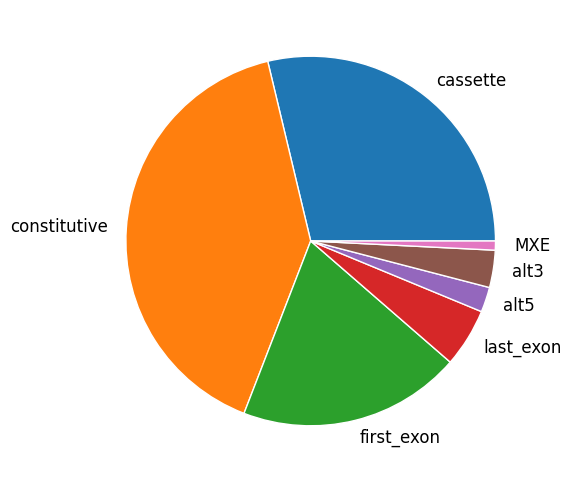

In [164]:
fig, ax = plt.subplots(figsize=(6, 6))


size = 0.4

# ax.pie(df_['annotated'].value_counts(),
#        radius=size, 
#        colors=sns.color_palette(palette='Greys'),
#        wedgeprops={'linewidth': 1.0, 'edgecolor': 'white', 'width':.2},
#        startangle=0
#       )


ax.pie(df['event_type'].value_counts().loc[['cassette','constitutive','first_exon','last_exon','alt5','alt3','MXE']],
      labels=df['event_type'].value_counts().loc[['cassette','constitutive','first_exon','last_exon','alt5','alt3','MXE']].index,
      radius = 1,
      wedgeprops={'linewidth': 1.0, 'edgecolor': 'white', 'width':1},
      textprops={'size': 'large'},
      colors=sns.color_palette(palette='tab10')[:7]+['w'],
 
      )

ax.set(aspect="equal")
fig.show()

In [55]:
cassette = df[df['event_type'] == 'cassette']

In [56]:
cassette

,chromosome,start,end,strand,intron_motif,n_cells,gene_id_start,gene_id_end,n_genes,gene_id,gene_name,size,intron_group,intron_group_size,n_genes_per_intron_group,grouping,name,exon,event_type,exon_length
2,chr1,1655485,1657255,-,2,51,ENSG00000248333,ENSG00000248333,1,ENSG00000248333,CDK11B,1770,CDK11B_chr1_1655485_-,2,1,three_prime,CDK11B_chr1:1655485-1657255,chr1:1657256-1657302:-,cassette,46.0
4,chr1,6186817,6192929,-,2,2925,ENSG00000116251,ENSG00000116251,1,ENSG00000116251,RPL22,6112,RPL22_chr1_6186817_-,3,1,three_prime,RPL22_chr1:6186817-6192929,chr1:6192930-6193054:-,cassette,124.0
9,chr1,7749792,7751198,+,1,538,ENSG00000171735,ENSG00000171735,1,ENSG00000171735,CAMTA1,1406,CAMTA1_chr1_7751198_+,2,1,three_prime,CAMTA1_chr1:7749792-7751198,chr1:7749771-7749791:+,cassette,20.0
12,chr1,7961736,7962762,+,1,6147,ENSG00000116288,ENSG00000116288,1,ENSG00000116288,PARK7,1026,PARK7_chr1_7962762_+,4,1,three_prime,PARK7_chr1:7961736-7962762,chr1:7961679-7961735:+,cassette,56.0
18,chr1,8656442,8792403,-,2,82,ENSG00000142599,ENSG00000142599,1,ENSG00000142599,RERE,135961,RERE_chr1_8656442_-,6,1,three_prime,RERE_chr1:8656442-8792403,chr1:8792404-8792588:-,cassette,184.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7137,chr7,134962935,134965305,+,1,11,ENSG00000122786,ENSG00000122786,1,ENSG00000122786,CALD1,2370,CALD1_chr7_134965305_+,2,1,three_prime,CALD1_chr7:134962935-134965305,chr7:134962820-134962934:+,cassette,114.0
7140,chr5,138319375,138328483,-,2,30,ENSG00000158402,ENSG00000158402,1,ENSG00000158402,CDC25C,9108,CDC25C_chr5_138328483_-,2,1,five_prime,CDC25C_chr5:138319375-138328483,chr5:138319219-138319374:-,cassette,155.0
7143,chr5,132487131,132487925,-,2,95,ENSG00000125347,ENSG00000125347,1,ENSG00000125347,IRF1,794,IRF1_chr5_132487131_-,2,1,three_prime,IRF1_chr5:132487131-132487925,chr5:132487926-132488025:-,cassette,99.0
7148,chr2,164722523,164727968,-,2,71,ENSG00000082438,ENSG00000082438,1,ENSG00000082438,COBLL1,5445,COBLL1_chr2_164727968_-,2,1,five_prime,COBLL1_chr2:164722523-164727968,chr2:164722425-164722522:-,cassette,97.0


In [57]:
#cassette.to_csv('introns_cassette_only.csv')

In [58]:
!conda list

# packages in environment at /c4/home/derek/miniconda3/envs/scquint_4:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
aiofiles                  22.1.0             pyhd8ed1ab_0    conda-forge
aiosqlite                 0.18.0             pyhd8ed1ab_0    conda-forge
anndata                   0.8.0                    pypi_0    pypi
anyio                     3.6.2              pyhd8ed1ab_0    conda-forge
appdirs                   1.4.4                    pypi_0    pypi
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py310h5764c6d_3    conda-forge
asttokens                 2.2.1              pyhd8ed1ab_0    conda-forge
attrs                     22.2.0             pyh71513ae_0    conda-forge
babel                     2.12.1             pyhd8ed1ab_1    conda-forg